# Transmission

In [1]:
%matplotlib inline
import numpy as np
np.seterr(divide='ignore') # Ignore divide by zero in log plots
from scipy import signal
import scipy.signal
from numpy.fft import fft, fftfreq
import matplotlib.pyplot as plt
#import skrf as rf # pip install scikit-rf if you want to run this one

First, let's set up a traditional, full-precision modulator and plot the spectrum of that as a baseline

In [2]:
def prbs(n=0, taps=[]):
    state = [1]*n
    shift = lambda s: [sum([s[i] for i in taps]) % 2] + s[0:-1]
    out = []
    for i in range(2**n - 1):
        out.append(state[-1])
        state = shift(state)
    return out
prbs9 = lambda: prbs(n=9, taps=[4,8])

def make_carrier(freq=None, sample_rate=None, samples=None, phase=0):
  t = (1/sample_rate)*np.arange(samples)
  return np.real(np.exp(1j*(2*np.pi*freq*t - phase)))

def modulate_gmsk(bits, carrier_freq=2.402e9, sample_rate=5e9, baseband=False):
    symbol_rate = 1e6 # 1Mhz
    BT = 0.5
    bw = symbol_rate*BT/sample_rate

    samples_per_symbol = int(sample_rate/symbol_rate)
    
    # This looks scary but it's just a traditional gaussian distribution from wikipedia
    kernel = np.array([(np.sqrt(2*np.pi/np.log(2))*bw)*np.exp(-(2/np.log(2))*np.power(np.pi*t*bw, 2)) for t in range(-5000,5000)])
    kernel /= sum(kernel) # Normalize so things amplitude after convolution remains the same
    
    rotation = np.repeat(bits, sample_rate/symbol_rate)*2.0 - 1.0
    smoothed_rotation = np.convolve(rotation, kernel,mode='same')

    angle_per_sample = (np.pi/2.0)/(samples_per_symbol)
    current_angle = 0
    modulated = np.zeros((len(smoothed_rotation),), dtype=np.complex64) # Represents I and Q as a complex number
    i = 0
    for bit in smoothed_rotation:
      current_angle += angle_per_sample*bit
      modulated[i] = np.exp(1j*current_angle)
      i += 1

    if baseband:
        return modulated
    
    I = make_carrier(freq=carrier_freq, sample_rate=sample_rate, samples=len(modulated), phase=0)
    Q = make_carrier(freq=carrier_freq, sample_rate=sample_rate, samples=len(modulated), phase=np.pi/2)

    return np.real(modulated)*I + np.imag(modulated)*Q

Now let's look at the FFT of this...

(-40.0, 0.0)

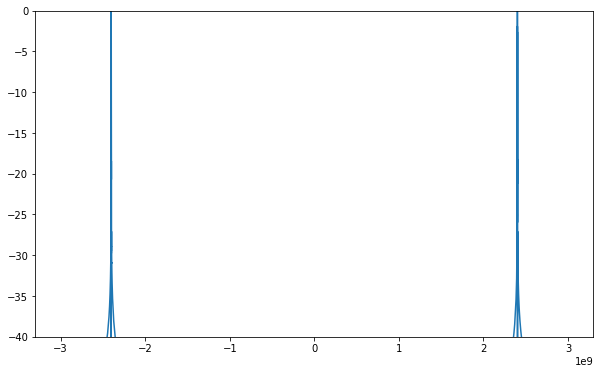

In [4]:
sample_rate = 6e9
modulated = modulate_gmsk(prbs9(), sample_rate=sample_rate)

fftm = np.abs(fft(modulated))
fftm = fftm/np.max(fftm)

fftbins = fftfreq(len(modulated), 1/sample_rate)

plt.figure(figsize=(10,6))
plt.plot(fftbins, 10*np.log10(fftm))
plt.gca().set_ylim(-40, 0)

This is clean (as one would expect), now let's see what happens if we reduce things to 1-bit of precision by just rounding

# The Naive Approach (Rounding)

(0.0, 3000000000.0)

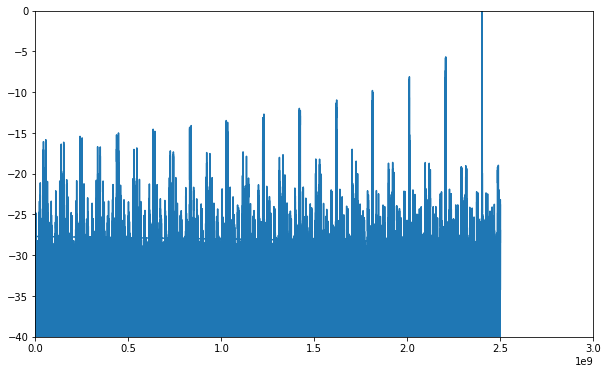

In [48]:
sample_rate=5e9

modulates_5g = modulated = np.sign(modulate_gmsk(prbs9(), sample_rate=sample_rate))

fftm = np.abs(fft(modulated))
fftm = fftm/np.max(fftm)

fftbins = fftfreq(len(modulated), 1/sample_rate)

plt.figure(figsize=(10,6))
plt.plot(fftbins, 10*np.log10(fftm))
plt.gca().set_ylim(-40, 0)
plt.gca().set_xlim(0, 3e9)

_Oof_ this is not pretty. What's happening here is that (I think) the aliases are mixing with each other to produce these interference paterns. In this case, it looks like the big subharmonics are spaced about 200Mhz which makes sense given the alias of 2.402ghz at 2.698ghz when sampling at 2.5ghz.

(0.0, 3000000000.0)

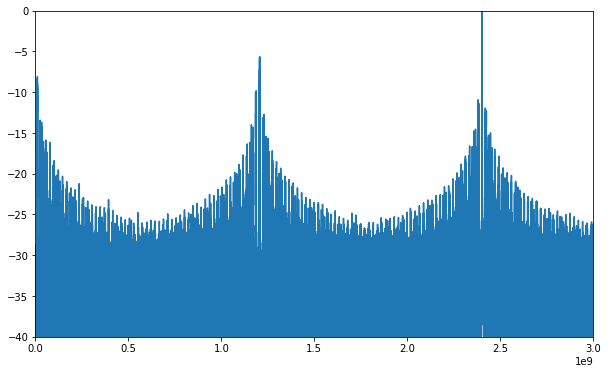

In [47]:
sample_rate = 6e9

modulated_6g = modulated = np.sign(modulate_gmsk(prbs9(), sample_rate=sample_rate))

fftm = np.abs(fft(modulated))
fftm = fftm/np.max(fftm)

fftbins = fftfreq(len(modulated), 1/sample_rate)

plt.figure(figsize=(10,6))
plt.plot(fftbins, 10*np.log10(fftm))
plt.gca().set_ylim(-40, 0)
plt.gca().set_xlim(0, 3e9)

Ok, in this case, the alias is at `3 + (3 - 2.402) = 3.6ghz`. The difference between this and 2.402ghz is about 1.2ghz, which looking at the next big peak, looks to be about 1.2ghz, so this makes sense. From this math, we can intuit that it's a good idea for the sample rate to be a whole number multiple of the carrier frequency. In the ideal case, 4 times the carrier:

(0.0, 3000000000.0)

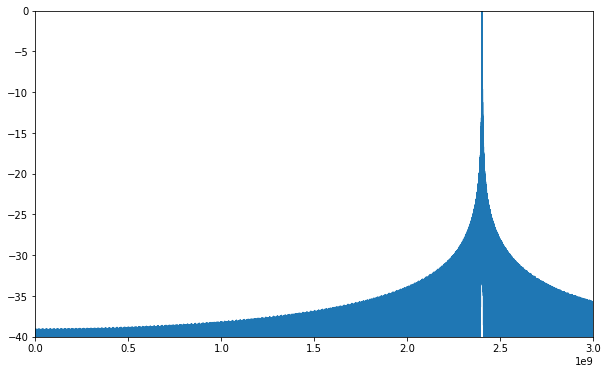

In [57]:
sample_rate = 2.402e9*4

modulated_4x = modulated = np.sign(modulate_gmsk(prbs9(), sample_rate=sample_rate))

fftm = np.abs(fft(modulated))
fftm = fftm/np.max(fftm)

fftbins = fftfreq(len(modulated), 1/sample_rate)

plt.figure(figsize=(10,6))
plt.plot(fftbins, 10*np.log10(fftm))
plt.gca().set_ylim(-40, 0)
plt.gca().set_xlim(0, 3e9)

There a couple of challenges here, however:

1. In order to get the clean(ish) spectrum, we have to clock the output frequency at a rate relative to the carrier frequency. If we only intended to use one frequency, this would be fine but Bluetooth (as an example) hops around frequency constantly by design. This might be doable, but it's kind of painful (this might require various SERDES resets which aren't instantaneous)
2. At 2.402ghz, 4x this would be... 9.6ghz, which is too fast for my (low-end-ish) SERDES which maxes out around 6ghz.

# Adding a Reconstruction Filter

In order to prevent a friendly visit from an unmarked FCC van, it's more or less mandatory that we filter noise outside of the band of interest. In our case, I have a tiny 2.4Ghz surface mount band pass filter that I've put onto a test board. This is the delightfully named "DEA252450BT-2027A1" which is a surface mount part which has a frequency response of:

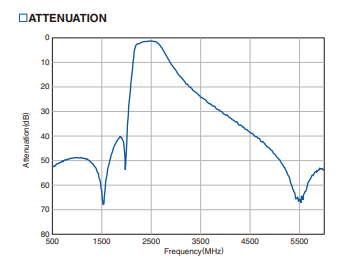

To (more fully) characterize this filter, I hooked it up to a NanoVNA2 and saved its S parameters using a NanoVNA Saver:

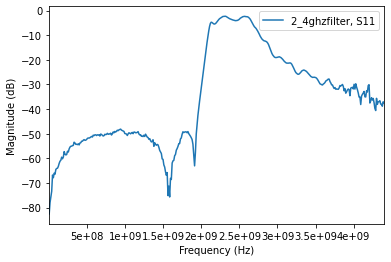

In [40]:
# pip install scikit-rf if you want to run this one
# Note: running this before we've plotted anything, borks matplotlib
import skrf as rf
filter2_4 = rf.Network('2_4ghzfilter.s2p')
filter2_4.s21.plot_s_db()

Hey that's not too far off from data sheet (at least up to 4.4Ghz). 

To turn this into a filter, we can use the scipy-rf to compute an impulse response which we can then convolve with our input data to see what the filtered output would be:

Timestep 3.2641464908425124e-11 seconds, frequency 3.063588e+10 hz


(0.0, 300.0)

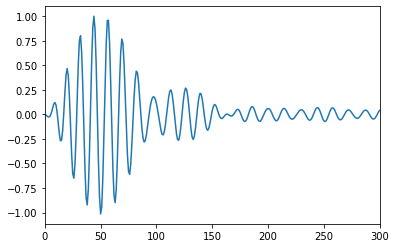

In [41]:
ts, ms = filter2_4.s21.impulse_response()
impulse_response = ms[list(ts).index(0):]
impulse_response = impulse_response/np.max(impulse_response)
tstep = ts[1] - ts[0]
print("Timestep {} seconds, frequency {:e} hz".format(tstep, 1/tstep))
plt.plot(impulse_response)
plt.gca().set_xlim(0, 300)

This is great and all but the impulse response is sampled at north of 30ghz (!). Our output serdes runs at around 6ghz so let's resample this to that rate

274


(0.0, 50.0)

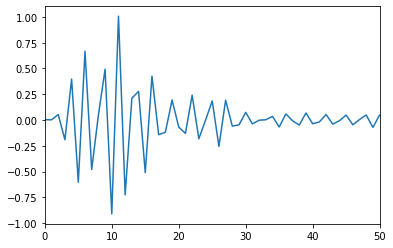

In [42]:
# Truncate the impulse response so we can get relatively close to 6ghz
trunc = impulse_response[:-4]
size = int((tstep*(len(trunc) - 1))/(1/6e9) + 1)
print(size)

impulse_response_6g = scipy.signal.resample(impulse_response, size)
plt.plot(impulse_response_6g)
plt.gca().set_xlim(0, 50)

Not quite as pretty, but it's what we need. Let's verify that this does "the thing" by filtering our 6ghz signal:

(0.0, 3000000000.0)

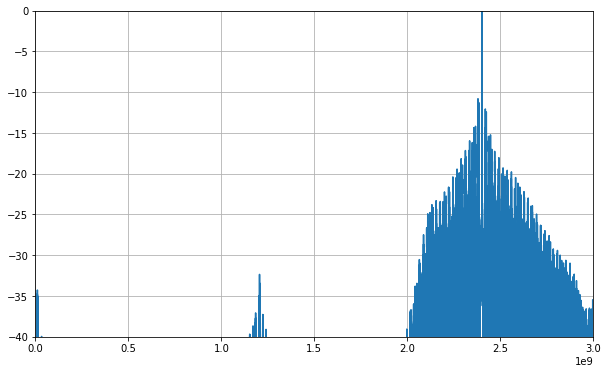

In [45]:
sample_rate=6e9

fftm = np.abs(fft(np.convolve(modulated_6g, impulse_response_6g, mode="same")))
fftm = fftm/np.max(fftm)

fftbins = fftfreq(len(fftm), 1/sample_rate)

plt.figure(figsize=(10,6))
plt.plot(fftbins, 10*np.log10(fftm))
plt.grid(b=True)
plt.gca().set_ylim(-40, 0)
plt.gca().set_xlim(0, 3e9)

This looks better, but the passband for my filter is still super wide (hundreds of MHz, not surprising for a 50c filter, I should look at B39242B9413K610 which is a $1 surface acoustic wave filter). We see some nontrivial imaging up to -12db, which is... not great.

What to do?

# Delta Sigma Modulation

A way around this is to use something called Delta Sigma Modulation. The way to think about this conceptually is that we keep a running sum of values we've output (think of this as the error) and factor this into the value we decide to output (versus just blindly rounding the current value). Further, you can filter this feedback loop to "shape" the noise to different parts of the spectrum (that we can filter out elsewhere).

A good place to read about this is [Wikipedia](https://en.wikipedia.org/wiki/Delta-sigma_modulation#Oversampling). In [Novel Architectures for Flexible and Wideband All-digital Transmitters](https://ria.ua.pt/bitstream/10773/23875/1/Documento.pdf) by Rui Fiel Cordeiro, Rui proposes using a filter that has a zero at the carrier of interest, which looks like the following

In [50]:
def pwm2(sig, k=1.0):
  z1 = 0.0
  z2 = 0.0
  out = np.zeros((len(sig,)))

  for i in range(len(sig)):
    v = sig[i] - (k*z1 + z2)
    out[i] = np.sign(v)
    z2 = z1
    z1 = v - out[i]

  return out

To be clear, `pwm2` is replacing `np.sign`

(-40.0, 0.0)

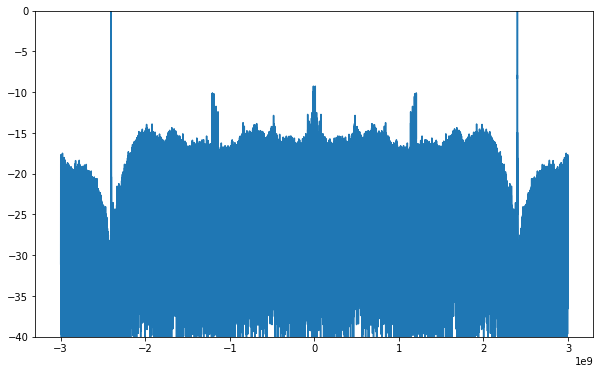

In [51]:
sample_rate = 6e9

modulated = modulate_gmsk(prbs9(), sample_rate=sample_rate)
modulatedsd5 = modulated = pwm2(modulated, k=-2.0*np.cos(2.0*np.pi*2.402e9/sample_rate))

fftm = np.abs(fft(np.sign(modulated)))
fftm = fftm/np.max(fftm)

fftbins = fftfreq(len(modulated), 1/sample_rate)

plt.figure(figsize=(10,6))
plt.plot(fftbins, 10*np.log10(fftm))
plt.gca().set_ylim(-40, 0)

Now let's filter this with our output filter

(0.0, 3000000000.0)

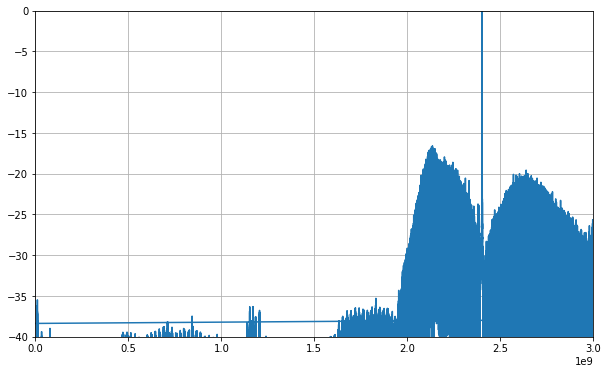

In [53]:
fftm = np.abs(fft(np.convolve(modulatedsd5, impulse_response_6g, mode="same")))
fftm = fftm/np.max(fftm)

fftbins = fftfreq(len(fftm), 1/sample_rate)

plt.figure(figsize=(10,6))
plt.plot(fftbins, 10*np.log10(fftm))
plt.grid(b=True)
plt.gca().set_ylim(-40, 0)
plt.gca().set_xlim(0, 3e9)

This is better in the immediate vicinity of our signal. 

You'll notice on the wikipedia page that we can use increasing filter orders to increase the steepness of the valley around our signal of interest.

On one hand this is good, but because our filter is not very good (tm) this actually results in higher peaks than we'd like at around 2.2ghz.

Given that our filter is... not that good, can we design the filter in the modulator to compliment it?

# Filter-Aware Sigma Delta Modulator

I lay no claim to this awesome work by the folks who wrote pydsm, but it's great -- feed it an impulse response for a reconstruction filter and it will optimize a noise transfer function that matches it:


In [139]:
from pydsm.ir import impulse_response
from pydsm.delsig import synthesizeNTF, simulateDSM, evalTF
from pydsm.delsig import dbv, dbp
from pydsm.NTFdesign import quantization_noise_gain
from pydsm.NTFdesign.legacy import q0_from_filter_ir
from pydsm.NTFdesign.weighting import ntf_fir_from_q0

In [12]:
H_inf = 1.5
q0 = q0_from_filter_ir(49, impulse_response_6g)
ntf_opti = ntf_fir_from_q0(q0, H_inf=H_inf)


Calling CVXOPT ...
     pcost       dcost       gap    pres   dres   k/t
 0:  2.7990e-17 -1.0000e+00  1e+02  8e+00  1e+01  1e+00
 1: -3.6109e-02  3.1817e-02  1e+01  1e+00  2e+00  4e-01
 2:  1.7741e-01  1.5919e-01  2e+00  2e-01  3e-01  4e-02
 3:  1.4325e-01  1.3608e-01  4e-01  9e-02  1e-01  2e-02
 4:  1.4744e-01  1.4441e-01  1e-01  3e-02  4e-02  5e-03
 5:  1.3596e-01  1.3446e-01  4e-02  1e-02  2e-02  2e-03
 6:  1.3486e-01  1.3401e-01  2e-02  6e-03  7e-03  6e-04
 7:  1.3313e-01  1.3283e-01  5e-03  2e-03  3e-03  2e-04
 8:  1.3241e-01  1.3234e-01  1e-03  4e-04  5e-04  4e-05
 9:  1.3233e-01  1.3229e-01  5e-04  2e-04  3e-04  2e-05
10:  1.3224e-01  1.3223e-01  1e-04  4e-05  5e-05  3e-06
11:  1.3223e-01  1.3223e-01  5e-05  2e-05  2e-05  8e-07
12:  1.3223e-01  1.3223e-01  4e-05  1e-05  2e-05  7e-07
13:  1.3222e-01  1.3222e-01  1e-05  4e-06  5e-06  2e-07
14:  1.3222e-01  1.3222e-01  9e-06  3e-06  4e-06  1e-07
15:  1.3222e-01  1.3222e-01  1e-06  4e-07  5e-07  2e-08
16:  1.3222e-01  1.3222e-01  5

Let's see how well we did. Anecdotally, this is not a _great_ solution (likely constrained by the low oversampling) but I'd wager this is because the oversampling rate is super low.

Text(0.5, 0.98, 'Output filter and NTFs')

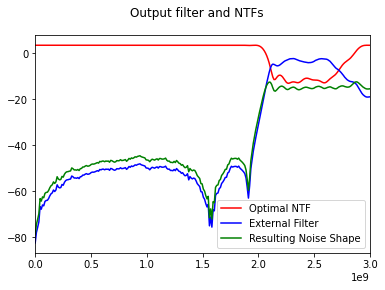

In [13]:
# Take the frequency response
samples = filter2_4.s21.s_db[:,0,0]
# Normalize the samples
ff = filter2_4.f/6e9

# Compute frequency response data
resp_opti = evalTF(ntf_opti, np.exp(1j*2*np.pi*ff))

# Plot the output filter, 
plt.figure()
plt.plot(ff*6e9, dbv(resp_opti), 'r', label="Optimal NTF")
plt.plot(ff*6e9, samples, 'b', label="External Filter")
plt.plot(ff*6e9, dbv(resp_opti) + samples, 'g', label="Resulting Noise Shape")
plt.gca().set_xlim(0, 3e9)
plt.legend(loc="lower right")
plt.suptitle("Output filter and NTFs")

Ok, so it's not amazing but definitely an improvement. But now that we've got this monstrous 49 coefficient NTF, how do we modulate with it?

Fortunately we have the pydsm to the rescue!

In [152]:
sample_rate = 6e9
modulated = modulate_gmsk(prbs9(), sample_rate=sample_rate)
xx_opti = simulateDSM(modulated, ntf_opti)

(0.0, 3000000000.0)

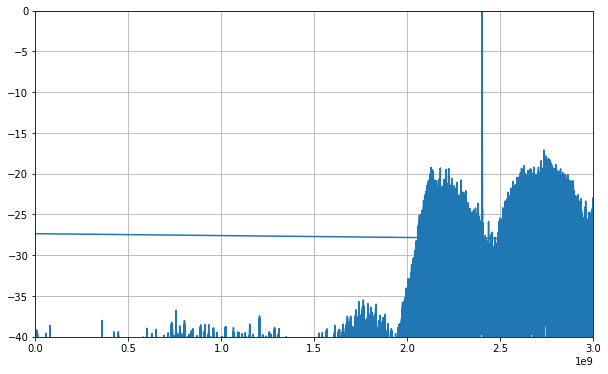

In [153]:
fftm = np.abs(fft(np.convolve(xx_opti[0], impulse_response_6g, mode="same")))
fftm = fftm/np.max(fftm)

fftbins = fftfreq(len(fftm), 1/sample_rate)

plt.figure(figsize=(10,6))
plt.plot(fftbins, 10*np.log10(fftm))
plt.grid(b=True)
plt.gca().set_ylim(-40, 0)
plt.gca().set_xlim(0, 3e9)

Ok, so we've basically "filled in the valley" with the peaks from eithe sides. We've cut the max spurs down by about 3db. Not amazing, but not bad!

After looking at how impressive I could get a saw filter to look, I realized I should order one (CBPFS-2441) and try with that. Unfortunately, the datasheets only show _drawing_ of parameters (and only phase) and actual s2p files are impossible to find. This seems dumb. Nevertheless, https://apps.automeris.io/wpd/ exists which allow you to extimate a graph from an image.

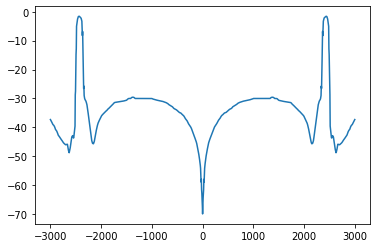

In [151]:
import csv
from scipy.interpolate import interp1d

traced = np.array([(float(f), float(d)) for f,d in csv.reader(open('saw_filter_traced.csv'))])

# Interpolate to 600 equally spaced points (this means 1200 total, so 1200 * 5MHz -> 6GHz sampling rate)
x = traced[:,0]
y = -1*traced[:,1]
f = interp1d(x, y)
x = np.array(np.linspace(5, 3000, 600))
y = np.array(f(x))

x = np.concatenate((np.flip(x)*-1, np.array([0]), x))

# In FFT format
y_orig = 10**(np.concatenate((np.array([-70]), y, np.flip(y)))/10)
y = 10**(np.concatenate((np.flip(y), np.array([-70]), y))/10.0)

plt.plot(x, 10*np.log10(y))

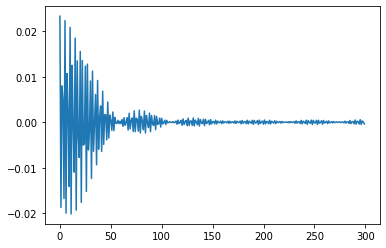

In [136]:
impulse = np.fft.ifft(y_orig)
impulse_trunc = impulse[:300]

plt.plot(np.real(impulse_trunc))

In [141]:
H_inf = 1.5
q0 = q0_from_filter_ir(49, np.real(impulse_trunc))
ntf_opti = ntf_fir_from_q0(q0, H_inf=H_inf)

/home/ben/playground/onebitbt/env/lib/python3.8/site-packages/numpy/matrixlib/defmatrix.py:137: ComplexWarning: Casting complex values to real discards the imaginary part
  return new.astype(intype)



Calling CVXOPT ...
     pcost       dcost       gap    pres   dres   k/t
 0: -1.2279e-17 -1.0000e+00  1e+02  7e+00  1e+01  1e+00
 1: -1.1511e-01 -7.2425e-02  1e+01  1e+00  2e+00  4e-01
 2:  7.0947e-02  5.6415e-02  2e+00  2e-01  3e-01  5e-02
 3:  5.0736e-02  3.9864e-02  9e-01  1e-01  2e-01  3e-02
 4:  7.9992e-02  7.6907e-02  1e-01  3e-02  4e-02  6e-03
 5:  7.2586e-02  7.0471e-02  5e-02  1e-02  2e-02  2e-03
 6:  7.4297e-02  7.3471e-02  2e-02  5e-03  7e-03  6e-04
 7:  7.3422e-02  7.3070e-02  5e-03  2e-03  2e-03  1e-04
 8:  7.3245e-02  7.3063e-02  2e-03  8e-04  1e-03  5e-05
 9:  7.3275e-02  7.3101e-02  2e-03  8e-04  1e-03  5e-05
10:  7.3014e-02  7.2976e-02  4e-04  2e-04  2e-04  8e-06
11:  7.2939e-02  7.2933e-02  6e-05  3e-05  4e-05  1e-06
12:  7.2928e-02  7.2925e-02  3e-05  1e-05  2e-05  5e-07
13:  7.2920e-02  7.2920e-02  5e-06  2e-06  3e-06  8e-08
14:  7.2919e-02  7.2919e-02  2e-06  9e-07  1e-06  3e-08
15:  7.2919e-02  7.2919e-02  4e-07  2e-07  3e-07  5e-09
16:  7.2919e-02  7.2919e-02  3

Text(0.5, 0.98, 'Output filter and NTFs')

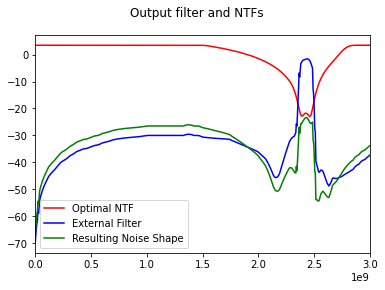

In [147]:
# Take the frequency response
samples = 10*np.log10(y)
# Normalize the samples
ff = x*1e6/6e9

# Compute frequency response data
resp_opti = evalTF(ntf_opti, np.exp(1j*2*np.pi*ff))

# Plot the output filter, 
plt.figure()
plt.plot(ff*6e9, dbv(resp_opti), 'r', label="Optimal NTF")
plt.plot(ff*6e9, samples, 'b', label="External Filter")
plt.plot(ff*6e9, dbv(resp_opti) + samples, 'g', label="Resulting Noise Shape")
plt.gca().set_xlim(0, 3e9)
plt.legend(loc="lower left")
plt.suptitle("Output filter and NTFs")

In [148]:
sample_rate = 6e9
modulated = modulate_gmsk(prbs9(), sample_rate=sample_rate)
xx_opti = simulateDSM(modulated, ntf_opti)

(0.0, 3000000000.0)

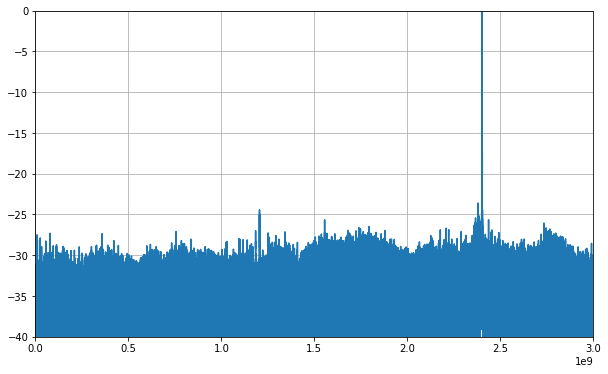

In [150]:
fftm = np.abs(fft(np.convolve(xx_opti[0], impulse_trunc, mode="same")))
fftm = fftm/np.max(fftm)

fftbins = fftfreq(len(fftm), 1/sample_rate)

plt.figure(figsize=(10,6))
plt.plot(fftbins, 10*np.log10(fftm))
plt.grid(b=True)
plt.gca().set_ylim(-40, 0)
plt.gca().set_xlim(0, 3e9)

Wow, the baseline noise level has dropped by almost 10db! Impressive!

# Symbol Dictionaries

Now that we've figured out how much we can most

In [24]:
opt_power = np.var(np.convolve(xx_opti[0], impulse_response_6g, mode="same"))
orig_power = np.var(np.convolve(modulatedsd5, impulse_response_6g, mode="same"))
print(opt_power, orig_power)

12.868409476176861 11.639275222860583
